
# 문제정의
이 대회는 많은 사람을 죽음으로 몰고 간 `Titanic 호 침몰 사건`을 주제로 다룬다.


생존에 영향을 미친 여러 요인이 있겠지만, 대회에서 주어진 Train 승객들의 정보만으로 Test 승객들의 생존 여부를 예측해보려고 한다.


생존과 연루되어 있다고 생각되는 몇 가지의 요소들에 대해 분석하여 어떤 조건을 갖춘 그룹들이 생존할 확률이 더 높았는지에 대해 알아보려고 한다.




# 데이터 수집

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string
from collections import Counter
import matplotlib as mpl
import random
from copy import deepcopy
from collections import defaultdict
from pandas.plotting import parallel_coordinates
warnings.filterwarnings(action = 'ignore')
plt.rcParams['font.family'] = 'KBIZmjo M'
%matplotlib inline

In [2]:
train = pd.read_csv('Desktop/데이터분석/titanic/train.csv')
test = pd.read_csv('Desktop/데이터분석/titanic/test.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

----------------------------------------------------
총 891명의 탑승자가 있다.(학습대상) 



하지만 Age, Cabin, Embarked는 몇몇 탑승자들의 정보가 누락되어있다.

- Age : 177명 누락(약 20%)
- Cabin : 687명 누락(약 77%)
- Embarked : 2명 누락(약 0.2%)


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

---------------------------------------------
test탑승자의 정보도 일부 누락되어있다. --> Age, Fare, Cabin  

In [45]:
train.Survived.value_counts() 

0    549
1    340
Name: Survived, dtype: int64

In [46]:
Dead_num = 549
Survived_num = 342

-----------------------------------------
전체 train탑승객 중 사망자는 549명, 생존자는 342명이다.

# 데이터 전처리
데이터를 다루기 쉽도록 가공한다.

- ## 중복데이터 삭제

In [9]:
train = train.drop_duplicates()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [10]:
test = test.drop_duplicates()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


- ## 불필요한 컬럼 삭제

In [11]:
ticket_dict = defaultdict(list)
for t_num , p_id in zip(train.Ticket, train.PassengerId):
    ticket_dict[t_num].append(p_id)

In [12]:
cnt = 0 #동승자 수+1(자기자신)과 Ticket번호가 동일한 승객수와 맞지 않는 경우 count
sp_dict = defaultdict(list)#key : sibsp+parch , value : passengerid
for k,v in ticket_dict.items():
    for s1, s2, p_id in zip(train.loc[train['Ticket']==k, 'SibSp'],train.loc[train['Ticket']==k, 'Parch'], train.loc[train['Ticket']==k,'PassengerId']):
        sp_dict[s1+s2].append(p_id) 
        if s1+s2+1 != len(v):
            cnt += 1
print(cnt)

288


--------------------------------------------------------------------
동승자는 Ticket번호가 모두 같을 것이기에 

동일 Ticket번호 개수 = SibSp + Parch + 1(자기자신) 일것이라 생각했다.

그런데 둘의 값이 다른 승객이 288명으로 꽤 많다.



In [15]:
#활용하지 않을 컬럼 drop
train = train.drop(['Name', 'SibSp', 'Parch' ], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB


In [16]:
test = test.drop(['Name', 'SibSp', 'Parch'], axis = 1)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null object
Age            332 non-null float64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(2), object(4)
memory usage: 29.4+ KB


----------------------------------
Name : 칭호를 분리해서 분석해볼 수 있지만 칭호는 Pclass, Fare 등 대체 할 수 있는 컬럼이 많기에 drop

SibSp, Parch : 동승자는 Ticket 컬럼 하나로 알아보는 것이 좋을 것 같다. Ticket으로는 동승자 수뿐만아니라 동승자가 누구인지까지 알아낼 수 있으므로 Ticket을 남겨두는 것이 더 좋은 선택이라 생각한다. 

- ## 데이터 타입 바꾸기

In [17]:
#알파벳 별 숫자 부여(대문자)
Cabin_dict = defaultdict(int)
for i,j in enumerate(range(65,91)):
    Cabin_dict[chr(j)] = i+1

In [18]:
#맨앞 알파벳만 따서 알파벳별 숫자 부여 (즉, string -> int)
for c, idx in zip(train.loc[train.Cabin.notnull()].Cabin, train.loc[train.Cabin.notnull()].index):
    train.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
train[train['Cabin'].notnull()].head(5)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
1,2,1,1,female,38.0,PC 17599,71.2833,3,C
3,4,1,1,female,35.0,113803,53.1000,3,S
6,7,0,1,male,54.0,17463,51.8625,5,S
10,11,1,3,female,4.0,PP 9549,16.7000,7,S
11,12,1,1,female,58.0,113783,26.5500,3,S


In [19]:
#test도 적용
for c, idx in zip(test.loc[test.Cabin.notnull()].Cabin, test.loc[test.Cabin.notnull()].index):
    test.set_value(idx,'Cabin', Cabin_dict[c[0].upper()])
test[test['Cabin'].notnull()].head(5)

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
12,904,1,female,23.0,21228,82.2667,2,S
14,906,1,female,47.0,W.E.P. 5734,61.1750,5,S
24,916,1,female,48.0,PC 17608,262.3750,2,C
26,918,1,female,22.0,113509,61.9792,2,C
28,920,1,male,41.0,113054,30.5000,1,S


In [20]:
for i in ['Sex', 'Embarked']:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
#string -> int
train['Sex'].cat.categories = [1,2]
test['Sex'].cat.categories = [1,2]
train['Embarked'].cat.categories = [1,2,3]
test['Embarked'].cat.categories = [1,2,3]

In [21]:
train.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked
0,1,0,3,2,22.0,A/5 21171,7.2500,NaN,3
1,2,1,1,1,38.0,PC 17599,71.2833,3,1
2,3,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,3
3,4,1,1,1,35.0,113803,53.1000,3,3
4,5,0,3,2,35.0,373450,8.0500,NaN,3


---------------
이제 Ticket을 제외한 나머지 컬럼의 데이터 타입은 int 또는 float이다.

- ## 결측치 처리

train 데이터)
    - Age : 다른 데이터로 추정하여 대체
    - Cabin : 그냥 두거나 다른 데이터로 추정하여 대체(분석 후 결정)
    - Embarked : 해당 행 삭제
    
test 데이터)
    - Age : 다른 데이터로 추정하여 대체
    - Fare : 다른 데이터로 추정하여 대체
    - Cabin : 그냥 두거나 다른 데이터로 추정하여 대체(분석 후 결정)
    

In [22]:
#Embarked결측치 삭제
train = train.drop(train.loc[train.Embarked.isnull()].index) 
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            712 non-null float64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 57.5+ KB


In [83]:
from sklearn.ensemble import RandomForestRegressor
def predict (dat, target, feature):#전체 데이터, 대상 컬럼, 예측에 활용될 컬럼list
    #target값이 Null인것과 Null이 아닌 것 구분
    Not_Null = dat.loc[dat[target].notnull()]
    Is_Null = dat.loc[dat[target].isnull()]
    
    Is_Null[target] = Is_Null[target].astype('str')
    
    #랜덤포레스트 회귀를 활용한다.
    rfModel = RandomForestRegressor()
    
    #feature에 있는 피처의 값을 바탕으로 학습시킨다.
    rfModel.fit(Not_Null[feature], Not_Null[target])
    
    #학습한 값을 바탕으로 예측한다.
    predicted_val = rfModel.predict(X = Is_Null[feature])
    
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    Is_Null_cpy = Is_Null
    Not_Null_cpy= Not_Null
    
    #결측치가 있는 데이터 프레임에 예측값을 넣어줌
    Is_Null_cpy[target] = predicted_val
    
    #결측치가 없는 데이터 프레임에 예측한 값이 있는 데이터프레임을 합친다.
    dat = Not_Null_cpy.append(Is_Null_cpy)
    dat[target] = dat[target].astype('float')
    
    dat.reset_index(inplace = True)
    dat.drop('index', inplace = True, axis =1)
    return dat

In [24]:
#나이 예측
train_age = predict(train,'Age',['Pclass', 'Fare','Sex','Embarked'])
train_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            889 non-null float64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 50.6+ KB


In [25]:
#나이 예측 후
train_age.Age.describe()

count    889.000000
mean      29.705625
std       13.612295
min        0.420000
25%       21.000000
50%       28.216667
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [26]:
#나이 예측 전
train.Age.describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [27]:
#test도 예측
#먼저 Fare부터
test = predict(test, 'Fare', ['Pclass','Sex'])
#이후 Age 예측
test_age = predict(test, 'Age', ['Pclass', 'Fare','Sex','Embarked'])
test_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Sex            418 non-null category
Age            418 non-null float64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null category
dtypes: category(2), float64(2), int64(2), object(2)
memory usage: 20.7+ KB


In [28]:
#예측 후
test_age.Age.describe()

count    418.000000
mean      29.605707
std       13.104007
min        0.170000
25%       22.000000
50%       27.000000
75%       36.375000
max       76.000000
Name: Age, dtype: float64

In [47]:
#예측 전
test.Age.describe()

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64

In [50]:
#Dead_num , Survived_num 갱신
Dead_num = len(train[train.Survived==0])
Survived_num = len(train[train.Survived==1])

In [86]:
train_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null category
Age            889 non-null float64
Ticket         889 non-null object
Fare           889 non-null float64
Cabin          202 non-null object
Embarked       889 non-null category
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 50.6+ KB



# 데이터 마이닝
데이터를 다양한 시각으로 관찰 후 가설을 세우고 검정할 것이다.

In [30]:
def standardization(data): #표준화
    m = data.mean()
    s = data.std()
    return [(i-m)/s for i in data]

def normalization(data): #정규화
    minn = data.min()
    maxx = data.max()
    return[(i-minn)/(maxx-minn) for i in data]

In [31]:
#다수결 정하는 함수
def majority_vote(labels):
    votes = Counter(labels)
    print(votes)
    res, num = votes.most_common(1)[0]
    cnt = 0
    #동점 체크(labels가 거리 오름차순으로 정렬되었다는 가정하에)
    for v in votes.values():
        if v == num:
            cnt += 1
    if cnt > 1:
        return majority_vote(labels[:-1])
    return res

In [32]:
print(majority_vote(sorted([1,3,4,5,12,3,2,2,3,1,2,1])))

Counter({1: 3, 2: 3, 3: 3, 4: 1, 5: 1, 12: 1})
Counter({1: 3, 2: 3, 3: 3, 4: 1, 5: 1})
Counter({1: 3, 2: 3, 3: 3, 4: 1})
Counter({1: 3, 2: 3, 3: 3})
Counter({1: 3, 2: 3, 3: 2})
Counter({1: 3, 2: 3, 3: 1})
Counter({1: 3, 2: 3})
Counter({1: 3, 2: 2})
1


- ## 나이가 아주 어리거나 많고 여자일수록 생존 확률이 높을 것이다.

In [33]:
#연령대 분류 함수
def AgeClassify(k):
    if k<10.0: 
        return 0
    elif k<20.0:#10대
        return 10
    elif k<30.0:#20대
        return 20
    elif k<40.0:#30대
        return 30
    elif k<50.0:#40대
        return 40
    elif k<60.0:#50대
        return 50
    elif k<70.0:#60대
        return 60
    elif k<80.0:#70대
        return 70
    elif k>=80.0:
        return 80

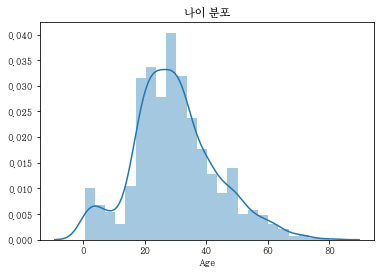

In [88]:
plt.title('나이 분포')
sns.distplot(train_age.Age)
plt.show()

In [91]:
train_age.describe()

,PassengerId,Survived,Pclass,Age,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.705625,32.096681
std,256.998173,0.486260,0.834700,13.612295,49.697504
min,1.000000,0.000000,1.000000,0.420000,0.000000
25%,224.000000,0.000000,2.000000,21.000000,7.895800
50%,446.000000,0.000000,3.000000,28.216667,14.454200
75%,668.000000,1.000000,3.000000,37.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,512.329200


-------------------------
20대~30대 후반까지의 승객이 가장 많고, 최고 고령자는 80세이다.

다음은 연령대별 생존확률에 대해 알아보겠다.

In [92]:
age_dict = defaultdict(int) #key : 연령대, value : 해당하는 사람 수 
for i in train_age.Age:
    age_dict[AgeClassify(i)] += 1
age_dict

defaultdict(int,
            {20: 290,
             30: 228,
             50: 52,
             0: 64,
             10: 120,
             40: 109,
             60: 19,
             70: 6,
             80: 1})

In [93]:
#key: 연령 ,value: 생존자 수
age_surv_dict = defaultdict(int)
for i,j in zip(train_age.Age, train_age.Survived):
    age_surv_dict[AgeClassify(i)] += j

for k,v in age_dict.items():
    age_surv_dict[k] /= v #해당 연령 생존자 수/ 해당 연령 수

age_surv_dict

defaultdict(int,
            {20: 0.33448275862068966,
             30: 0.37280701754385964,
             50: 0.40384615384615385,
             0: 0.625,
             10: 0.43333333333333335,
             40: 0.3577981651376147,
             60: 0.2631578947368421,
             70: 0.0,
             80: 1.0})

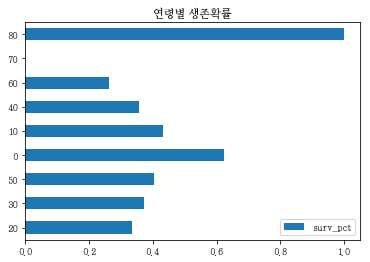

In [127]:
pd.DataFrame.from_dict(age_surv_dict, orient = 'index', columns = ['surv_pct']).plot.barh()
plt.title('연령별 생존확률')
plt.show()

-----------
70대의 생존확률은 0%이고, 80대는 100%라고 나오지만, 70, 80대의 승객은 거의 없기 때문에 신뢰할 수 없다.


가장 생존 확률이 높은 것은 10세 미만인 승객인 것을 확인할 수 있다.

In [147]:
#여자 생존 확률
fe_num = len(train.loc[train.Sex == 1].PassengerId)
surv_fe_pct = len(train.loc[(train.Survived == 1) & (train.Sex == 1)].PassengerId)/fe_num
surv_fe_pct

0.7403846153846154

In [151]:
#남자 생존 확률
m_num= len(train.loc[train.Sex == 2].PassengerId)
surv_m_pct = len(train.loc[(train.Survived == 1) &(train.Sex == 2)].PassengerId)/m_num
surv_m_pct

0.18890814558058924

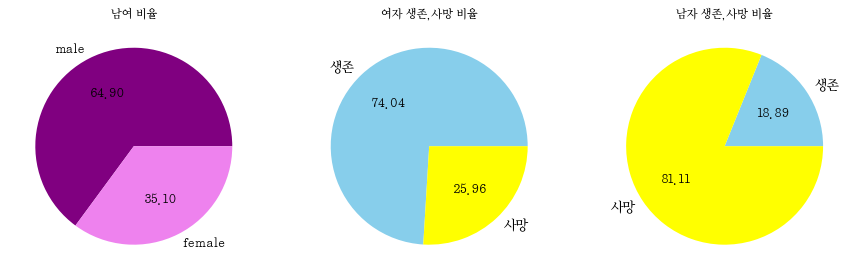

In [156]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].set_title('남여 비율')
ax[0].pie(train.Sex.value_counts(), labels = ['male','female'],colors = ['purple','violet'],autopct = '%.2f',textprops={'fontsize': 14} )


ax[1].set_title('여자 생존,사망 비율')
ax[1].pie([surv_fe_pct, 1-surv_fe_pct], labels = ['생존','사망'],colors = ['skyblue','yellow'],autopct = '%.2f',textprops={'fontsize': 14} )


ax[2].set_title('남자 생존,사망 비율')
ax[2].pie([surv_m_pct, 1-surv_m_pct], labels = ['생존','사망'],colors = ['skyblue','yellow'],autopct = '%.2f',textprops={'fontsize': 14} )

plt.show()


----------------
여자인 승객 중 생존자는 74.04%

남자인 승객 중 생존자는 18.89%



성별이 1(여자)이면 생존했을 확률이 높다는 것을 뒷받침해주는 결과이다.

In [157]:
#여자이고 나이가 어린 승객

In [158]:
#여자이고 나이가 50이상인 승객

In [ ]:
#남자이고 나이가 어린 승객 --> 여자이고 나이가 어린 승객과 비교하여 나이와 성별 중 어느것에 더 큰 가중치를 둬야하는지 확인

- ## 동승자가 없는(혼자 온) 승객은 사망 확률이 높을 것이다.

In [59]:
#Ticket
t_together_survived = 0 #동일 Ticket을 가진 승객이 있고, 생존한 승객 count
t_alone_survived = 0 #동일 Ticket을 가진 승객이 없고(즉, 혼자), 생존한 승객 count
t_alone_dead  = 0 #혼자이고 사망한 승객count
t_together_cnt =0 #len(v) >1인 승객 count
t_alone_cnt = 0 #len(v) <= 1인 승객 count
for k,v in ticket_dict.items():
    if len(v) <=1:
        for vv in v:
            t_alone_cnt += 1
            try:
                if int(train[train['PassengerId']==vv].Survived) == 1:
                    t_alone_survived += 1
                if int(train[train['PassengerId']==vv].Survived) == 0:
                    t_alone_dead += 1
            except:
                continue
    else:
        for vv in v: 
            t_together_cnt += 1 
            try:
                if int(train[train['PassengerId']==vv].Survived) == 1:
                    t_together_survived += 1
            except:
                continue

a_surv_pct = t_alone_survived/Survived_num
surv_a_pct = t_alone_survived/t_alone_cnt
a_dead_pct = t_alone_dead/Dead_num
dead_a_pct = t_alone_dead/t_alone_cnt
t_surv_pct = t_together_survived / Survived_num 
surv_t_pct = t_together_survived /t_together_cnt
print('P(a|surv) = ' , a_surv_pct)
print('P(surv|a) = ', surv_a_pct)
print('P(a|dead) = ',a_dead_pct)
print('P(dead|a) = ', dead_a_pct)
print('P(t|surv) = ',t_surv_pct)
print('P(surv|t) = ',surv_t_pct)

P(a|surv) =  0.47941176470588237
P(surv|a) =  0.2979890310786106
P(a|dead) =  0.6994535519125683
P(dead|a) =  0.7020109689213894
P(t|surv) =  0.5205882352941177
P(surv|t) =  0.5145348837209303


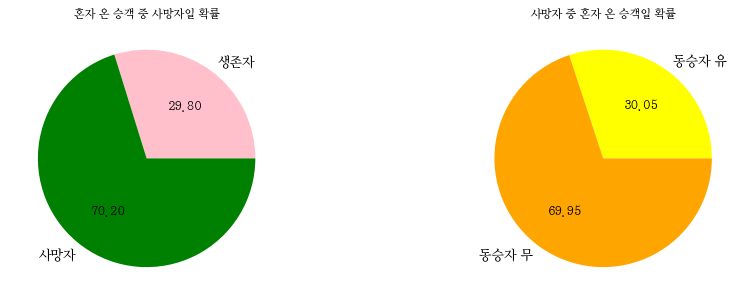

In [75]:
fig, ax = plt.subplots(1, 2, figsize = (15,5))
ax[0].set_title('혼자 온 승객 중 사망자일 확률')
ax[0].pie([1-dead_a_pct,dead_a_pct],labels=['생존자','사망자'],colors = ['pink','green'],autopct = '%.2f',textprops={'fontsize': 14})

ax[1].set_title('사망자 중 혼자 온 승객일 확률')
ax[1].pie([1-a_dead_pct,a_dead_pct],labels = ['동승자 유', '동승자 무'], colors = ['yellow', 'orange'], autopct = '%.2f' ,textprops={'fontsize': 14})
plt.show()

------------------------------
- 생존자 중 혼자 온 승객은 47.94%

- 혼자 온 승객 중 생존자일 확률은 29.80%

- <strong>사망한 승객 중 혼자 온 승객일 확률은 69.95%

- 혼자 온 승객 중 사망자일 확률은 70.20%</strong>

- 생존자 중 동승자가 있는 승객일 확률은 52.34%

- 동승자가 있는 승객 중 생존자일 확률은 52.03% 


결론)


'동승자가 있는 승객이 생존할 확률이 높다'고 할순없지만,


<strong>'동승자가 없는 혼자 온 승객은 사망할 확률이 높다'</strong>고 할 수 있다. 

- ## Pclass가 1이고 Fare가 높은 승객은 생존 확률이 높을 것이다. 

-----------------------------------------
사회적 지위가 높을 수록 더 높은 요금을 내는 사람들이 많다. 



따라서<strong> Pclass가 높을 수록 Fare도 높을 확률이 높다.</strong>

------------------------------
## 결론
B,D,E로 시작하는 객실에 묵은 승객들의 <strong>생존확률이 70%가 넘는다</strong>는 사실을 알게 되었다.

그래서 해당 객실 승객들의 나이, 성별, 사회적 지위, 요금, 승선한 항구에 대해 알아보았다.

정리를 하자면,


나이는 20~40대가 가장 많고, 0~50대가 전체의 93%를 차지한다.



성별비율은 거의 1:1이다.



사회적 지위는 <strong>대부분(86%)이 1등급</strong>이다.



<strong>비싼 요금을 낸 승객들은 모두 사회적 지위가 높은 승객들이고, 이 승객들은 해당 객실에 포함</strong>되어 있다.



승선 항구는 S항구가 가장 많고(64%), Q항구는 거의 없다(2%)


여기서 가장 눈에 띄는 것은, 해당 객실 승객들이 대부분 <strong>사회적 지위가 높은 사람들</strong>이라는 것이다.


그리고 이 사회적 지위가 높은 사람들은 대부분 <strong>높은 요금</strong>을 지불했다.


그래서 해당 객실 승객들의 생존확률이 높은 것에 가장 큰 영향을 준 것은 <strong>Pclass와 Fare</strong>이고, B,D,E로 시작하는 객실은 비싸고 좋은 객실이었을 것이라 생각한다.


----------------------------------------------



# 예측 모델 만들기

In [ ]:

def Pclass_sol(data, pid, m): #pclass에 따른 점수 부여
    if data[data['PassengerId']== pid].Pclass[0]  == 1:
        return 0.5
#     if data.loc[data.PassengerId == pid].loc[data.Pclass== 1:
#         return 0.5
    elif data.loc[data.PassengerId == pid].Fare[0] >m:
        return 0.2
    return 0
    
def Cabin_sol(data, pid):#B,D,E에 있으면 점수 부여
    for c in data.loc[data.Cabin.notnull()].loc[data.PassengerId == pid].Cabin :  
        #Cabin이 B,D,E에 있으면
        if c[0] in ['B','D','E']:
            return 0.2
    return 0

def Alone_sol(data,pid):
    if data.loc[data.SibSp == 0 & data.Parch == 0].PassengerId == pid:
        return -0.2 - Null_sol(data, pid)
    return 0

def Null_sol(data, pid):
    if data.loc[data.Age.isnull() | data.Cabin.isnull()].PassengerId== pid:
        return -0.2
    return 0

def final_sol(data):
    m = data.Fare.mean()
    tmp = 0   
    res = defaultdict(int)
    for p in data.PassengerId:
        tmp = Pclass_sol(data,p,m) + Cabin_sol(data,p) + Alone_sol(data,p) + Null_sol(data, p)
        if tmp <= 0 :
            res[p] = 0
        else:
            res[p] = 1
    return res

In [ ]:
final_sol(train)